In [1]:
from IPython.core.display import HTML
from notebook_css import css
HTML(css)

In [113]:
import os
mnist_dir = '/notebooks/Freund\'s_Shrine/Data/MNIST/mnist_npy'

x_s_train = np.load(os.path.join(mnist_dir, 'mnist_train_images.npy'))
y_s_train = np.load(os.path.join(mnist_dir, 'mnist_train_labels.npy'))
x_s_test = np.load(os.path.join(mnist_dir, 'mnist_test_images.npy'))
y_s_test = np.load(os.path.join(mnist_dir, 'mnist_test_labels.npy'))

[7 2 1 0 4 1 4 9 5 9]


<IPython.core.display.Javascript object>


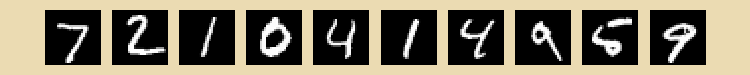

[7 3 4 6 1 8 1 0 9 8]


<IPython.core.display.Javascript object>


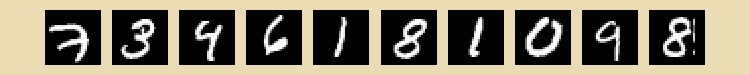

In [114]:
print(np.argmax(y_s_test[:10], 1))
image_plot([_.reshape(28,28) for _ in x_s_test[:10]])
print(np.argmax(y_s_train[:10], 1))
image_plot([_.reshape(28,28) for _ in x_s_train[:10]])

In [81]:
import math
import itertools
import IPython
import numpy as np
% matplotlib notebook
% matplotlib notebook
import matplotlib.pyplot as plt

if IPython.get_ipython():
    import ipywidgets as widgets
else:
    import matplotlib.widgets as widgets
from cycler import cycler
from collections import Iterable
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.colors import Normalize
from matplotlib.figure import figaspect
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection

import feature_visualization as fv
from Kant import ordinal
from switch import switch
from enn_v1_0 import ENN
from feature_visualization import md_display


# from importlib import reload
# reload(fv)
# fv = feature_visualization

class nn_visualizer(object):
    def __init__(self, x_s, y_s, nn, trace_dict):
        """
        :param x_s:
            2-d array-like. This is supposed to be the numpy-style training \
            set or test set, whereas `x_coords` and `y_coords` are the \
            corresponding matplotlib-style data!
        """
        """ alternatives: groupby, filter everytime, boolean indexing \
        everytime, np.indices. """
        #         self.x_coords_all_classes, self.y_coords_all_classes = [], []
        #         keyfunc = lambda xy: np.argmax(xy[1], 1)
        #         xy_s = sorted(zip(x_s, y_s), keyfunc)
        #         for k, g in itertools.groupby(xy_s, keyfunc):
        #             """ `g`: xy_class_j """
        #             x_s_class_j = np.array(list(g))[:, 0]
        self.x_s = x_s
        self.y_s = y_s
        """ a indexing array used to select samples of j-th class. """
        self._indices = lambda j: np.where(np.argmax(self.y_s, 1) == j)

        assert hasattr(nn, 'predict') and \
               hasattr(nn, 'logits') and \
               hasattr(nn, 'accuracy') and \
               hasattr(nn, 'config') and \
               hasattr(nn.config, 'num_of_class')
        self.nn = nn

        assert 'W' in trace_dict and \
               'b' in trace_dict and \
               'W_grad' in trace_dict and \
               'b_grad' in trace_dict and \
               'loss' in trace_dict
        self.trace_dict = trace_dict

        sampling_magnitude = 10
        self.grid = (sampling_magnitude, sampling_magnitude)
        self.x_s_test = fv.sampling(
            'square', 'numpy', sampling_magnitude)

        """ initialize the plotting config. (conn: connection) """
        fv.style_initialize(plt)
        plt.rc('axes', prop_cycle=cycler(color=['b', 'r']))
        self.var_type = 'all'
        self.var_trace_one_off = True
        self.conn_density = 1
        self.image_type = None
        """ influence the plot of image-gram of `weights` and `bias`. """
        self.image_one_off = True
        self.hist_type = None

        self.__function_sign()

        
    def __function_sign(self):
        self.func_map_dict = dict()
        sign = lambda ks, v: self.func_map_dict.update(dict.fromkeys(ks, v))
        sign(
            ['activation_func_plot', 'av_func_plot', 'af_plot', 'afp',
             'av_func', 'af'],
            '_nn_visualizer__activation_func_plot'
        )
        sign(
            ['vars_trace_plot', 'vt_plot', 'vtp', 'vars_plot', 'trace_plot',
             'vars_trace', 'vt'],
            '_nn_visualizer__vars_trace_plot'
        )
        sign(
            ['decision_boundary_plot', 'db_plot', 'decision_boundary', 'db'],
            '_nn_visualizer__decision_boundary_plot'
        )
        sign(
            ['transformation_plot', 't_plot', 't'],
            '_nn_visualizer__transformation_plot'
        )
        sign(
            ['image_plot', 'img_plot', 'im_plot', 'imp', 'ip', 'im', 'i'],
            '_nn_visualizer__image_plot'
        )
        sign(
            ['hist_plot', 'h_plot', 'hp', 'hist', 'h'],
            '_nn_visualizer__hist_plot'
        )

        
    def __update_data_and_params(self, step):
        self.params = self.trace_dict['W'][step], self.trace_dict['b'][step]

        """ logits of `train` and `test` data. """
        self.f1 = self.nn.logits(self.x_s, *self.params)
        self.f2 = self.nn.logits(self.x_s_test, *self.params)
        self.labels_test = self.nn.predict(
            self.x_s_test, *self.params, one_hot=False
        ).reshape(self.grid)

    
    """ one-off function """
    def dataset_plot(self):
        md_display('Step 1: Prepare the data set')
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        """ alternatives for styling: key-args, decorator, `prop_cycle`. """
        for class_j in range(self.nn.config.num_of_class):
            ax.plot(*self.x_s[self._indices(class_j)].T)
        ax.legend([
            'class %s' % (j + 1) for j in range(self.nn.config.num_of_class)])
        plt.show()

    
    """ [one-off | repeated] function  """
    def __vars_trace_plot(self):
        if self.initial:
            assert self.var_type in ('all', 'weights', 'gradients', 'loss')
            md_display('Step 3: Training Process Plotting')
            fv.jtplot.style('chesterish')
            fv.style_initialize(plt)

            """ var_trace location & switch statements count and location """

            def var_trace_plot(var_trace, var_type):
                assert var_trace.ndim == 3
                """ initialize the plotting params. """
                num_of_xcoords = var_trace.shape[0]
                num_of_line = var_trace.shape[1]
                num_of_col = var_trace.shape[2]
                x_coord_1st = 0 if var_type != 'gradients' else 1
                x_coords = range(x_coord_1st, num_of_xcoords + x_coord_1st)
                #         if var_trace != 'loss':
                fig, axes = plt.subplots(
                    1, num_of_col, figsize=(8, 4), sharex=True, sharey=True)
                fig.subplots_adjust(bottom=0.13)
                #         else:
                #         fig, axes = plt.subplots(
                #             2, 1, figsize=(11,22), sharex=True, sharey=True)
                axes = np.array(axes).flatten()

                """ determine the var type and plot. """
                for case in switch(var_type):
                    if case('weights') \
                            or case('gradients'):
                        legend = [
                                     r'$w(%s)$' % ''.join([
                                         r'' if not pow_ \
                                             else r'x_%s' % k if pow_ == 1 \
                                             else r'x^%s_%s' % (pow_, k) \
                                         for k, pow_ in enumerate(term_i)
                                     ]) for term_i in enn.fp_transformation] + [r'$bias$'] \
                            if case('weights') else [
                                                        r'$\partial{J}\ / \partial{w_{%sj}}$' % i
                                                        for i in range(num_of_line - 1)
                                                    ] + [r'$\partial{J}\ / \partial{bias_j}$']

                        """ stack `W` and `b` together can avoid redundant \
                        plotting code in the following. """
                        #                 var_trace = np.vstack((trace_dict['W'], trace_dict['b']))
                        for dim_j in range(num_of_col):
                            for i in range(num_of_line):
                                axes[dim_j].plot(
                                    x_coords,
                                    var_trace[:, i, dim_j], linestyle='-', marker=''
                                )
                            """ `legend` should be caculated finally here when \
                            var type is weights. """
                            if case('gradients'):
                                axes[dim_j].legend(
                                    [_.replace('j', str(dim_j)) for _ in legend])
                            else:
                                axes[dim_j].legend(legend)
                            axes[dim_j].set_title(
                                r'dimension %d of new space' % dim_j, y=1.05)
                            axes[dim_j].set_ylabel(var_type)
                            axes[dim_j].set_xlabel('step')
                            axes[dim_j].set_xticks([_ for _ in x_coords if _ % 2 == 0])
                        plt.show()
                        break
                    if case('loss'):
                        """ TODO: loss-elementwise & loss-dimwise """
                        lc_s, annot_s = [], []
                        for dim_j in range(num_of_col):
                            """
                            fisrt add x coordinates (`stack`), e.g:
                            [0.2    [0.3   ____\   [(0,0.2)    [(0,0.3) 
                             0.6],  -0.4]      /    (1,0.6)],  -(1,0.4)]  
                            then permute dims to adapt to the input format of \
                            `LineCollection` (`transpose`).
                            """
                            lines = np.transpose(
                                np.stack([
                                    np.broadcast_to(
                                        x_coords,
                                        (num_of_line, num_of_xcoords)).T,
                                    var_trace[:, :, dim_j]
                                ], axis=2),
                                (1, 0, 2)
                            )
                            """ split according to the type of class. """
                            #                         lines = np.split(lines, enn.config.num_of_class)
                            lc_s_dim_j = []
                            cmap_all_class = ['Blues', 'Reds']
                            color_all_class = ['b', 'r']
                            for cls_j in range(self.nn.config.num_of_class):
                                """ 
                                `ls_cls_j`: lines of class j 
                                `ss_j`: sample size of class j
                                """
                                ls_cls_j = lines[self._indices(cls_j)]
                                ss_j = len(ls_cls_j)
                                """ attention the two meanings of `j` """
                                lc = LineCollection(
                                    ls_cls_j,
                                    cmap=cmap_all_class[cls_j]
                                )
                                """ set the line colors """
                                lc.set_array(
                                    np.linspace(
                                        int(ss_j * 0.2), int(ss_j * 0.8), ss_j))
                                lc.set_clim(0, ss_j)
                                axes[dim_j].add_collection(lc)
                                lc_s_dim_j.append(lc)

                                axes[dim_j].plot(
                                    x_coords,
                                    np.mean(ls_cls_j[:, :, 1], 0),
                                    linestyle='-', color=color_all_class[cls_j], \
                                    linewidth=1.5, marker=''
                                )

                            axes[dim_j].autoscale()
                            axes[dim_j].set_title(
                                r'dimension %d of new space' % dim_j, y=1.05)
                            axes[dim_j].set_ylabel('loss per sample')
                            axes[dim_j].set_xlabel('step')
                            axes[dim_j].set_xticks([_ for _ in x_coords if _ % 2 == 0])
                            axes[dim_j].legend(handles=[
                                Patch(facecolor='b', label='class 1'),
                                Patch(facecolor='r', label='class 2')
                            ])
                            lc_s.append(lc_s_dim_j)

                            """ ref temporarily: https://stackoverflow.com/questions/7908636/possible-to-make-labels-appear-when-hovering-over-a-point-in-matplotlib """
                            annot = axes[dim_j].annotate(
                                "", xy=(0, 0), xytext=(4, 4),
                                textcoords="offset points",
                                bbox=dict(boxstyle="round", fc="c"),
                            )
                            annot.set_visible(True)
                            annot_s.append(annot)

                        def hover(event):
                            if event.inaxes:
                                """ idx of target ax. """
                                idx = list(axes).index(event.inaxes)
                                """ retrive lcs of all classes in the target ax. \
                                """
                                for j, lc in enumerate(lc_s[idx]):
                                    is_contain, idx_dict = lc.contains(event)
                                    if is_contain:
                                        annot_s[idx].xy = event.xdata, event.ydata
                                        """ ref temporarily: https://stackoverflow.com/questions/9647202/ordinal-numbers-replacement """
                                        """ find the sample size of `j-1` class. \
                                        """
                                        line_quantity_of_pre_classes = \
                                            np.sum(np.argmax(self.y_s, 1) < j) \
                                                if j > 0 else 0
                                        annot_s[idx].set_text(
                                            '%s sample' % \
                                            ordinal(idx_dict['ind'][0] +
                                                    line_quantity_of_pre_classes)
                                        )
                                        annot_s[idx].get_bbox_patch(). \
                                            set_alpha(0.4)
                                        annot_s[idx].set_visible(True)
                                        fig.canvas.draw_idle()
                                        return
                            for _ in annot_s: _.set_visible(False)
                            fig.canvas.draw_idle()

                        fig.canvas.mpl_connect("motion_notify_event", hover)
                        plt.show()
                        break
                    elif case('default'):
                        raise AssertionError('invalid var type!')

            if self.var_type == 'all' or self.var_type == 'weights':
                var_trace_plot(np.concatenate(
                    (self.trace_dict['W'], self.trace_dict['b'][:, np.newaxis, :]), \
                    1),
                    'weights'
                )
            if self.var_type == 'all' or self.var_type == 'gradients':
                var_trace_plot(np.concatenate(
                    (self.trace_dict['W_grad'], self.trace_dict['b_grad'] \
                        [:, np.newaxis, :]), 1),
                    'gradients'
                )
            if self.var_type == 'all' or self.var_type == 'loss':
                var_trace_plot(self.trace_dict['loss'], 'loss')
            fv.reset()
        else:
            pass

        
    """ obj.__activation_func_plot(){...update...?} """
    """ repeated function  """
    def __activation_func_plot(self):
        #         if one_off or (not one_off and self.initial):
        if self.initial:
            md_display('Step 4: Scalar-Valued Function Learned Plotting')

            global fig_af, axes_af, clim, surf_s
            fig_af = plt.figure(figsize=(8, 4))
            fig_af.subplots_adjust(left=0.05, right=0.89, wspace=0.04)

            """ determine the min and max of logits across the whole training\
            process. """
            clim = [0, 0]
            for params_ in zip(self.trace_dict['W'], self.trace_dict['b']):
                f2_ = self.nn.logits(self.x_s_test, *params_).T
                min_, max_ = np.min(f2_), np.max(f2_)
                if clim[0] > min_: clim[0] = min_
                if clim[1] < max_: clim[1] = max_

            axes_af, surf_s = [], []
            for dim_j in range(len(f2_)):
                ax = fig_af.add_subplot(1, len(f2_), dim_j + 1, projection='3d')
                ax.set_title(
                    'nonlinear function learned of dim %d' % dim_j, y=1.05)
                ax.set_zlim(*clim)
                axes_af.append(ax)
            axes_af[0]._shared_x_axes.join(*axes_af)
            axes_af[0]._shared_y_axes.join(*axes_af)

            global cbar_ax, m, cbar
            cbar_ax = fig_af.add_axes([0.92, 0.15, 0.015, 0.7])
            m = cm.ScalarMappable(cmap='coolwarm')
            m.set_array([])
            m.set_clim(*clim)
            cbar = plt.colorbar(m, cax=cbar_ax)

            self.initial = False
        else:
            for _ in surf_s: _.remove()
            surf_s.clear()

        for dim_j, ax in enumerate(axes_af):
            surf = ax.plot_surface(
                *self.x_s_test.T.reshape(2, *self.grid),
                self.f2[dim_j].reshape(self.grid),
                cmap='coolwarm'
            )
            surf.set_clim(*clim)
            surf_s.append(surf)

        plt.show()

        
    """ repeated function  """
    """ every func knows only about the message it receives. take func below \
    as an example, so the message is `self.initial`, and it doesn't know the \
    REASON why `self.initial` is that value! """
    def __decision_boundary_plot(self):
        if self.initial:
            md_display('Step 5: Decision Boundary Plotting')

            global fig_db, ax_db, db
            fig_db, ax_db = plt.subplots(figsize=(4.5, 4.5))
            fv.style_initialize(plt)
            ax_db.legend(handles=[
                Patch(facecolor='b', label='class 1'),
                Patch(facecolor='r', label='class 2')
            ])

            for class_j in range(self.nn.config.num_of_class):
                ax_db.plot(*self.x_s[self._indices(class_j)].T)
        else:
            for _ in db.collections: _.remove()
            acc_train = self.nn.accuracy(self.x_s, self.y_s, *self.params)
            print('Training Accuracy:', acc_train)

        db = ax_db.contourf(
            *self.x_s_test.T.reshape(2, *self.grid),
            self.labels_test,
            cmap='RdBu_r', alpha=0.6, zorder=-5
        )
        plt.show()

        
    """ repeated function  """
    def __transformation_plot(self):
        if self.initial:
            md_display('Step 6: Transformation Plotting')

            """ in mpl 2.2.3, there is no need `sharex[y]` any more when \
            `equal` is used. furthermore, the plot will fail to render if 、
            you use them both! """
            global fig_t, axes_t, trans_s
            trans_s = []
            fig_t, axes_t = plt.subplots(1, 2, figsize=(8, 4), )
            fig_t.subplots_adjust(left=0.06, right=0.93, wspace=0.08)
            """ `axis` will change data lim based current data. """
            fv.style_initialize(plt)

            for ax in axes_t:
                ax.axis('equal')
                ax.legend(handles=[
                    Patch(facecolor='b', label='class 1'),
                    Patch(facecolor='r', label='class 2')
                ])
            axes_t[0].set_title('original space', y=1.05)
            axes_t[1].set_title('transformed space', y=1.05)
            for class_j in range(self.nn.config.num_of_class):
                axes_t[0].plot(
                    *self.x_s[self._indices(class_j)].T, markersize=0.4)
                axes_t[1].plot(*self.f1[self._indices(class_j)].T)

            global con_s_1
            con_s_1 = fv.connection_plot(
                axes_t[1], axes_t[0], self.f1, self.x_s, self.conn_density)

            """ diagonal line """
            for ax in axes_t:
                ax.plot([-10, 0, 10], [-10, 0, 10], '--k', alpha=0.2, zorder=-5, linewidth=0.8)
                ax.plot([0], [0], 'ko', markersize=3, zorder=-5)
            """ priority: lim setter > sharex & sharey | autoscale_view"""
        else:
            for _ in trans_s: _.remove()
            trans_s.clear()

            for cls_j in range(self.nn.config.num_of_class):
                axes_t[1].lines[cls_j].set_data(
                    *self.f1[self._indices(cls_j)].T)

        for con, xy in zip(con_s_1, self.f1): con.xy1 = xy

        for ax, x_s in zip(axes_t, [self.x_s_test, self.f2]):
            trans = ax.pcolormesh(
                *x_s.T.reshape(2, *self.grid),
                self.labels_test,
                cmap='coolwarm', edgecolor='white', alpha=0.5, zorder=-1
            )
            ax.grid(True, linestyle='--', alpha=1.)
            trans_s.append(trans)

        """ css | dpi | figsize, ax size | tight """
        """ set_[]lim, ax.axis, updata_datalim, update_from_..., margin """
        new_xlim = min(-1, self.f2[:, 0].min()), max(1, self.f2[:, 0].max())
        new_ylim = min(-1, self.f2[:, 1].min()), max(1, self.f2[:, 1].max())

        """ ax.update_datalim not work. """
        """ seems the same as `ax.set_[x|y]lim`. """
        for ax in axes_t: ax.axis([*new_xlim, *new_ylim])

        """ ref: https://stackoverflow.com/questions/7386872/make-matplotlib-autoscaling-ignore-some-of-the-plots """
        """ only `set_lim` and `update_...` together can work? """
        axes_t[0].dataLim.update_from_data_xy(self.f2, ignore=False)
        axes_t[1].dataLim.update_from_data_xy(self.f2, ignore=False)

        plt.show()
    #     return (*trans_s, *con_s_1, *con_s_2, ax_, s)

    
    """ openning-to-outside function """
    def image_plot(array_s, title='', cols=10):
        assert isinstance(array_s, Iterable), 'no array data found!'
        fv.jtplot.style('gruvboxl')
        rows = math.ceil(len(array_s)/cols)
        global fig_im, axes_im, im_s
        fig_im, axes_im = plt.subplots(rows, cols, figsize=(6, 6/(cols/rows)))
        fig_im.subplots_adjust(left=0.06, right=0.94, top=0.94, bottom=0.06, )
        fig_im.suptitle(title)

        norm = Normalize(np.min(array_s), np.max(array_s))
        im_s = []
        for array, ax in zip(array_s, axes_im.flatten()):
            im = ax.imshow(np.atleast_2d(array), cmap='gray', norm=norm)
            im_s.append(im)
        for ax in axes_im.flatten():
            ax.axis('off')
        fv.reset()
        
    
    """ [one-off | repeated] function """
    def __image_plot(self):
        if not self.image_type:
            raise AttributeError('Argument: kwarg `image_type` required!')
        if self.image_type not in ('weights', 'bias', 'data', 'logits'):
            raise AttributeError('Unknown property %s' % self.image_type)
        
        for case in switch(self.image_type):
            if case('weights') \
            or case('bias'):
                k, idx = ('W', 0) if case('weights') else ('b', 1)
                """ one-off mode """
                if self.image_one_off:
                    nn_visualizer.image_plot(self.trace_dict[k])
                """ repeated mode """
                else:
                    if self.initial:
                        nn_visualizer.image_plot(self.params[idx])
                    else:
                        assert 'im_s' in globals()
                        im_s[0].set_data(np.atleast_2d(self.params[idx]))
                break
            if case('data'):
                """ one-off mode """
                nn_visualizer.image_plot(self.x_s)
                break
            if case('logits'):
                """ repeated mode """
                if self.initial:
                    nn_visualizer.image_plot(self.f1)
                else:
                    assert 'im_s' in globals()
                    for array, im in zip(self.f1, im_s):
                        im.set_data(np.atleast_2d(array))
        plt.show()

        
    """ [openning-to-outside | repeated] function """
    def hist_plot(array_s, suptitle=''):
        array_s = np.atleast_2d(array_s)
        """ qty: quantity """
        qty_of_hist = x_s.shape[1]
        rows = math.ceil(qty_of_fig / 3)
        cols = qty_of_fig if qty_of_fig < 4 else 3
        figsize = (3.5 * cols, 3.5 * rows) if cols < 3 else (9, 4.5 * rows)

        global fig_h, axes_h
        fig_h, axes_h = plt.subplots(
            rows, cols, figsize=figsize, sharey=True)
        fig_h.subplots_adjust(
            left=0.06, right=0.94, top=0.94, bottom=0.06)
        fig_h.suptitle(suptitle)

        min_, max_ = np.min(x_s), np.max(x_s)
        """ amplification factor """
        af = (10 ** 2) if max_ - min_ < 5 else 1
        bin_edge_range = [math.floor(min_ * af) / af, math.ceil(max_ * af) / af]
        #             print(bin_edge_range)
        bins = 10

        values_s = []
        for arr, ax in zip(array_s, axes_h.flatten()):
            ax.tick_params(labelsize=6.5)

            values, bin_edge_s, __ = ax.hist(
                arr, np.linspace(*bin_edge_range, bins + 1),
                color='c', alpha=0.5, ec='k', zorder=5
            )
            values_s += list(values)
            ax.set_xticks([_ for _ in bin_edge_s])
            ax.yaxis.set_tick_params(labelleft=True)
            ax.set_yticks(range(0, int(np.max(values_s)) + 1, 2))
        plt.show()

        
    def __hist_plot(self):
        if not self.hist_type:
            raise AttributeError('Argument: kwarg `image_type` required!')
        if self.hist_type not in ('weights', 'bias', 'data', 'logits'):
            raise AttributeError('Unknown property %s' % self.hist_type)
        
        for case in switch(self.hist_type):
            if case('weights') \
            or case('bias'):
                """ repeated mode """
                if not self.initial:
                    assert 'axes_h' in globals()
                    axes_h.cla()
                else:
                    print('Note: weights and bias are shown together.')
                
                params_ = np.concatenate(
                    (self.params[0], self.params[1][:, np.newaxis, :]), 1)
                nn_visualizer.hist_plot(
                        params_, 'all dims from a sample view')
                else:
                    im_s[0].set_data(np.atleast_2d(self.params[idx]))
                break
            if case('data'):
                """ one-off mode """
                nn_visualizer.image_plot(self.x_s)
                break
            if case('logits'):
                """ repeated mode """
                if self.initial:
                    nn_visualizer.image_plot(self.f1)
                else:
                    assert 'axes_h' in globals()
                    for array, im in zip(self.f1, im_s):
                        im.set_data(np.atleast_2d(array))
        plt.show()
    
    
    def __update(self, step, functions):
        self.initial = False
        self.__update_data_and_params(step)
        for f in functions:
            getattr(self, self.func_map_dict[f])()

            
    def visualize(self, *functions, **kwargs):
        assert functions, 'No Plotting Functions Given!'
        for k, v in kwargs.items():
            if hasattr(self, k):
                setattr(self, k, v)
            else:
                raise AttributeError('Unknown Keyword Arguments: %s!' % k)
        
        self.initial = True
        self.__update_data_and_params(0)
        
        functions = list(functions)
        for f in functions:
            if f in self.func_map_dict:
                f_name = self.func_map_dict[f]
                getattr(self, f_name)()
                if (f_name == '_nn_visualizer__vars_trace_plot' and 
                    self.var_trace_one_off) \
                or (f_name == '_nn_visualizer__image_plot' and 
                    self.image_type == 'data') \
                or (f_name == '_nn_visualizer__image_plot' and 
                    self.image_type == 'weights' and self.image_one_off) \
                or (f_name == '_nn_visualizer__image_plot' and 
                    self.image_type == 'bias' and self.image_one_off) \
                or (f_name == '_nn_visualizer__hist_plot' and 
                    self.hist_type == 'data'):
                    """ `None` here plays a role of placeholder in order not \
                    to influence the normal iteration of `functions`. """
                    functions[:0] = [None]
                    functions.remove(f)
            else:
                raise AttributeError('Unknown Plotting Functions!')
            
        functions = filter(lambda _: _ is not None, functions)
        widgets.interact(
            self.__update,
            step=widgets.IntSlider(min=0, max=len(self.trace_dict['W']) - 1),
            functions=widgets.fixed(functions)
        )

In [12]:
[x_coords, y_coords] = fv.sampling('quadratic', 'matplotlib', 50)
xy1 = np.array([x_coords, y_coords+0.4])
xy2 = np.array([x_coords, y_coords-0.45])
""" `x` here means input feature vector x """
x_s_train = np.hstack([xy1, xy2]).T
y_s_train = np.array([[1, 0]]*50 + [[0, 1]]*50)

enn = ENN(max_degree=1)    
trace_dict = enn.fit(x_s_train, y_s_train, 20, True)

training completed.


<IPython.core.display.Javascript object>


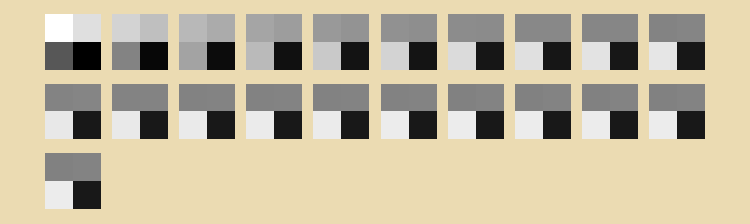

interactive(children=(IntSlider(value=0, description='step', max=20), Output()), _dom_classes=('widget-interac…

In [79]:
from importlib import reload
reload(fv)
enn_v = nn_visualizer(x_s_train, y_s_train, enn, trace_dict)    
# enn_v.dataset_plot()
# enn_v.visualize('db')
# enn_v.visualize('vt', var_type='all')
# enn_v.image_plot()
enn_v.visualize('image_plot', image_type='weights')

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">Step 6: Transformation Plotting</span></font>

<IPython.core.display.Javascript object>


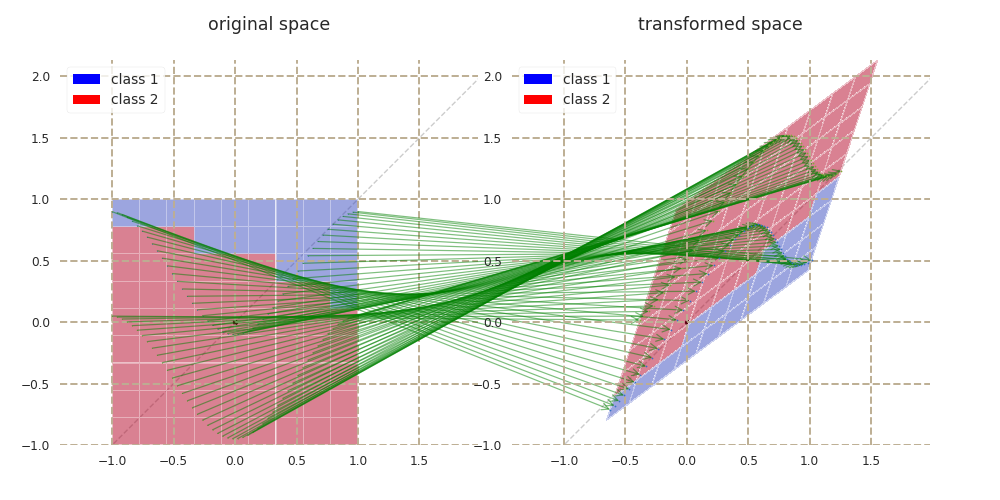

interactive(children=(IntSlider(value=0, description='step', max=20), Output()), _dom_classes=('widget-interac…

In [88]:
# del ax_db
enn_v.visualize('t')


In [122]:
enn_v.initial

False

<IPython.core.display.Javascript object>


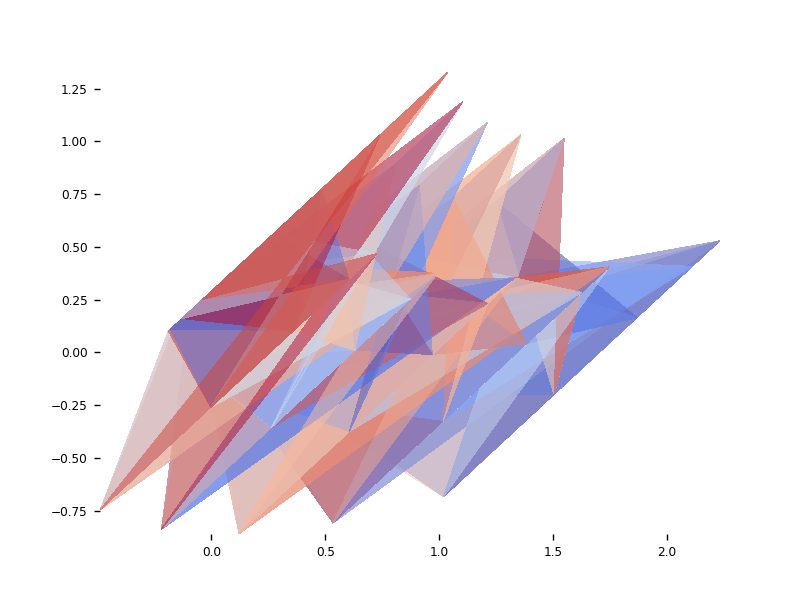

In [110]:
# print(*enn_v.f2.reshape(2, *enn_v.grid))
fig, ax = plt.subplots()
Z = np.random.random((10,10))
# Z = np.where(Z>0.5, 1, 0)
""" f2 is numpy-style """
ax.pcolormesh(*enn_v.f2.reshape(2, *enn_v.grid),Z , cmap='coolwarm', alpha=0.5)
plt.show()

In [36]:
"""
important notice: the matplotlib version is 2.1.0 and 2.2.3, and python version is 3.5.
"""



fv.reset()
    
    
sampling_magnitude = 10
grid = (sampling_magnitude, sampling_magnitude)
xy_coords_test = fv.sampling('square', 'matplotlib', sampling_magnitude)



def training_process():
    md_display('Step 2: Training Process')
    return enn, trace_dict



    
"""------------------"""

    
    



    
def update(step):
    """ `step`: the index of training step. """
    """ refreshing freq is too slow. how to optimize? """
    global params, labels_test, f, f1, f2, f3
    params = trace_dict['W'][step], trace_dict['b'][step]
    labels_test = enn.predict(
        xy_coords_test.T, *params, one_hot=False).reshape(grid)
    f = lambda _: enn.logits(_.T, *params).T
    f1, f2, f3 = f(xy1), f(xy2), f(xy_coords_test)
    
    #     image_plot(enn.logits(x_s_train, *params), 'transformed feature')
    #     activation_func_plot()
    #     decision_boundary_plot()
#     if initial:
#         yield transformation_plot()
#     else:
    return transformation_plot()
    

In [3]:
""" reconstruct into class? """
# print(get_terms_for_display(enn.fp_transformation))
enn, trace_dict = training_process()

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">Step 2: Training Process</span></font>

training completed.


In [70]:
del fig_db, ax_db, db
del params, labels_test, f, f1, f2, f3
del ax_, s
del update

<font face='Goudy Old Style' size=5><span style="color:rgb(0, 92, 84);">Step 5: Decision Boundary Plotting</span></font>

<IPython.core.display.Javascript object>


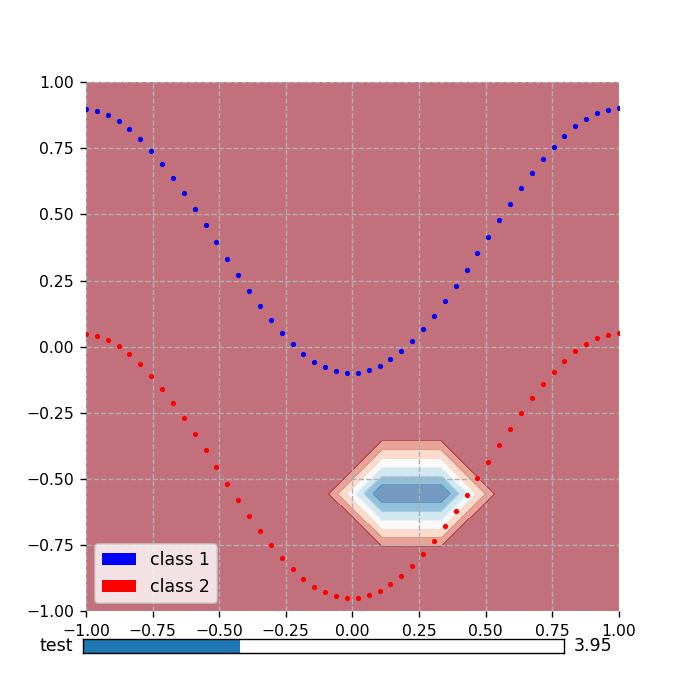

Training Accuracy: 0.5


0

In [68]:
import matplotlib.animation as animation

# dataset_plot()
# vars_trace_plot()
# initial = True
# activation_func_plot()



# transformation_plot()
""" fig and ax must be created outside the `interact`, else empty figure \
will be rendered. """
# image_plot(x_s_train, 'raw feature')
# next(update(0))


# ani = animation.FuncAnimation(fig_t, update, frames=20, interval=50, blit=True)
# ani.save('test.mp4', dpi=300)
# image_plot(x_s_train, 'raw feature')
# image_plot(trace_dict['W'], 'weights')
# image_plot(trace_dict['b'], 'bias')
# image_plot()

# plt.hist(x_s_train[:, 0])



[[ 0.84226179  0.13129936]
 [ 0.91456248  0.09447929]
 [ 0.9738286   0.06479326]
 [ 1.02044436  0.04213164]
 [ 1.05497301  0.02632691]
 [ 1.07814111  0.01715066]
 [ 1.09081851  0.01431024]
 [ 1.093995    0.01744551]
 [ 1.08875464  0.02612634]
 [ 1.07624872  0.03985132]
 [ 1.05766849  0.05804834]
 [ 1.03421852  0.08007746]
 [ 1.00709184  0.10523629]
 [ 0.97744731  0.13276837]
 [ 0.94639009  0.16187436]
 [ 0.91495538  0.19172601]
 [ 0.88409573  0.22148268]
 [ 0.85467183  0.25030974]
 [ 0.82744648  0.27739853]
 [ 0.80308149  0.30198681]
 [ 0.78213686  0.32337917]
 [ 0.76507164  0.3409664 ]
 [ 0.75224591  0.35424305]
 [ 0.74392319  0.3628223 ]
 [ 0.74027269  0.36644765]
 [ 0.74137108  0.36500072]
 [ 0.74720329  0.35850487]
 [ 0.75766237  0.3471245 ]
 [ 0.77254835  0.33116   ]
 [ 0.79156624  0.31103864]
 [ 0.81432367  0.28730178]
 [ 0.84032858  0.260589  ]
 [ 0.86898754  0.23161988]
 [ 0.89960535  0.20117419]
 [ 0.93138655  0.17007138]
 [ 0.96343945  0.13915019]
 [ 0.99478315  0.10924914]
 

<IPython.core.display.Javascript object>


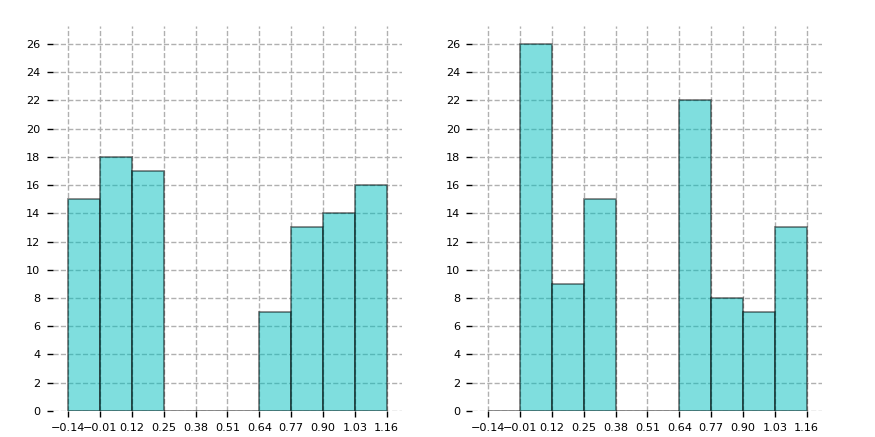

[-0.14, 1.16]


In [39]:
# dataset_plot()

    
initial = True
a = enn.logits(x_s_train, trace_dict['W'][-1], trace_dict['b'][-1])
# print(np.min(a), np.max(a))
# print(x_s_train[:, 1])
print(a)
hist_plot(a)

In [ ]:
trace_dict['W'][-1]

In [ ]:
from IPython.core.display import HTML
from notebook_css import css
HTML(css)

### Following Work
· visualize the gradients, weights, bias. (1)

· multiple graphs visualization in the case of max degree of freedom > 2. (2)

· visualize the space transformation. (3)

· increase the degree of freedom of ENN.

· try to analyze the 3-d data.

· XOR problem.

· add softmax, observe the independence among the gradients, and so on.

· spiral curve problem, conic problem, and so on.

· automatic derivatives calculation using sympy.

· optimize the calculation of value of the polynomial terms.

· linear cls (two line) & linear regression?

· would it converge faster when swapping the label blue and label red?

· remove the bias.

· 不规则的数据会怎样学习扭曲？batch呢？

· 如果是回归问题，转换又会变成什么样？

· w矩阵是如何从单位阵开始变成那样的？

· 样本不均衡

· 二次情况下，两个维度的分类器仍然保持对称吗？

### Design of Visualization Experiment
1.feature
- histogram, space distribution, image-gram

2.weights, bias
- image-gram, histogram
- trace, gradients trace

3.transformed feature
- historam, space transformation, image-gram
- non-linear activation function learned dimension-wise in new space

4.softmax probability
- space transformation, classification boundary

5.loss, loss-sample-wise
- trace with step, trace with weights ($loss_{dim\_j}$ trace about $k\verb|-|th\ sample$), pie chart (proportions from each sample in $\Delta loss_{dim\_j}$, or proportions from each dim in $\Delta loss$ about $k\verb|-|th\ sample$)


In [ ]:
import matplotlib as mpl
print(mpl.get_backend())
print(mpl.is_interactive())

In [ ]:
# global_lc_s[0].get_segments()[0]
figaspect(3/10)

<IPython.core.display.Javascript object>


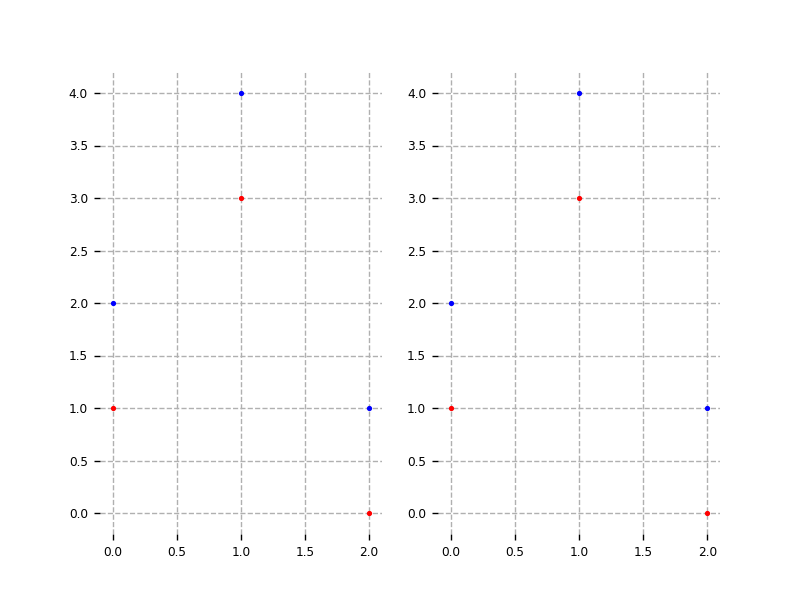

In [23]:
import matplotlib.pyplot as plt
from cycler import cycler

fv.reset()
plt.rc('axes', prop_cycle=cycler(color=['b', 'r', 'c']))
fig, axes = plt.subplots(1,2)
y = np.array([2,4,1])
axes[0].plot(y)
axes[0].plot(y-1)
axes[1].plot(y)
axes[1].plot(y-1)